In [4]:
import os, json, gc
from time import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

import torch
from torch import nn

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
train = sio.loadmat("../data/train.mat")
test = sio.loadmat("../data/test.mat")
ref = sio.loadmat("../data/reference.mat")

In [7]:
feature_name = ['TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 'ST R',
                'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L']

In [8]:
sample_x = train["0001"][0][0][0]
sample_x.shape

(319, 16, 1000)

In [9]:
class TrainSet(torch.utils.data.Dataset):
    
    user_ids = ["0001", "0002", "0003", "0004"]
    
    def __init__(self):
        super().__init__()
        
        # データの読み込み
        self.raw_set = sio.loadmat("../data/train.mat")
        
        # 各ユーザーの試行回数を格納
        self.trials = [self.raw_set[user_id][0][0][0].shape[0] for user_id in self.user_ids]
        
        
    def __len__(self):
        return sum(self.trials)
    
    def __getitem__(self, idx):
        user_idx = 0
        # ユーザーの試行回数に応じてidxを再取得
        while idx >= self.trials[user_idx]:
            idx -= self.trials[user_idx]
            user_idx += 1
        
        x = self.raw_set[self.user_ids[user_idx]][0][0][0][idx, :, :]
        y = self.raw_set[self.user_ids[user_idx]][0][0][1][idx, 0, :]
        
        return x, y

train_dataset = TrainSet()
# print(len(train_dataset))
x, y = next(iter(train_dataset))
print(x.shape, y.shape)

(16, 1000) (30,)


In [80]:
mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(16000, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 100, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(100, 30, dtype=torch.float32)
)

In [81]:
batch_size = 1
num_workers = 0
epochs = 30

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters())

def train_1epoch():
    runnning_loss = 0
    
    for i, data in enumerate(train_loader):
        x, y = data
        optimizer.zero_grad()
        
        output = mlp_model(x.to(torch.float32))

        loss = loss_fn(output.to(torch.float32), y.to(torch.float32))
        loss.backward()
        
        optimizer.step()
        
        runnning_loss += loss.item()
    
    return runnning_loss

train_history = []
mlp_model.to(device)
for epoch in tqdm(range(epochs)):
    mlp_model.train()
    train_loss = train_1epoch()
    print(f"[Epoch {epoch}] train loss: {train_loss:.5f}")
    train_history.append(train_loss)

  0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 0] train loss: 6097.63697
[Epoch 1] train loss: 4771.29082
[Epoch 2] train loss: 2429.14840
[Epoch 3] train loss: 1585.34191
[Epoch 4] train loss: 976.67872
[Epoch 5] train loss: 917.52561
[Epoch 6] train loss: 789.98139
[Epoch 7] train loss: 667.40199
[Epoch 8] train loss: 601.96151
[Epoch 9] train loss: 552.19335
[Epoch 10] train loss: 572.72941
[Epoch 11] train loss: 463.98219
[Epoch 12] train loss: 396.66656
[Epoch 13] train loss: 425.46143
[Epoch 14] train loss: 410.37514
[Epoch 15] train loss: 395.03054
[Epoch 16] train loss: 413.01845
[Epoch 17] train loss: 358.20491
[Epoch 18] train loss: 325.96439
[Epoch 19] train loss: 319.63059
[Epoch 20] train loss: 295.98485
[Epoch 21] train loss: 284.74734
[Epoch 22] train loss: 244.76515
[Epoch 23] train loss: 294.02749
[Epoch 24] train loss: 313.13291
[Epoch 25] train loss: 245.44998
[Epoch 26] train loss: 235.52356
[Epoch 27] train loss: 233.96754
[Epoch 28] train loss: 244.71504
[Epoch 29] train loss: 226.17032


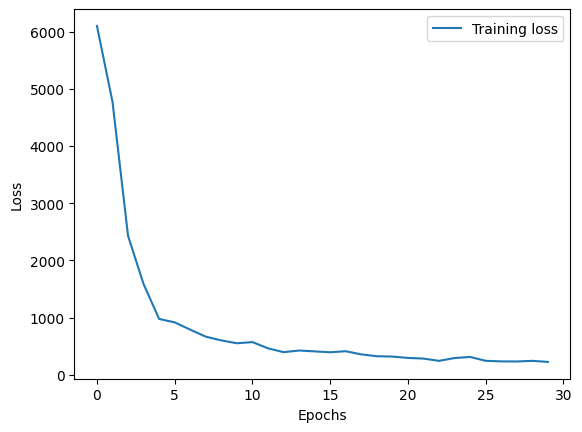

In [82]:
plt.plot(train_history, label="Training loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [84]:
torch.save(mlp_model, "../models/mlp_test.pt")

In [18]:
import torch
import torch.nn as nn

# データセット定義
class TrainSet(torch.utils.data.Dataset):
    
    user_ids = ["0001", "0002", "0003", "0004"]
    
    def __init__(self):
        super().__init__()
        
        # データの読み込み
        self.raw_set = sio.loadmat("../data/train.mat")
        
        # 各ユーザーの試行回数を格納
        self.trials = [self.raw_set[user_id][0][0][0].shape[0] for user_id in self.user_ids]
        
        
    def __len__(self):
        return sum(self.trials)
    
    def __getitem__(self, idx):
        user_idx = 0
        # ユーザーの試行回数に応じてidxを再取得
        while idx >= self.trials[user_idx]:
            idx -= self.trials[user_idx]
            user_idx += 1
        
        x = self.raw_set[self.user_ids[user_idx]][0][0][0][idx, :, :]
        x = x.reshape(1000, 16)
        y = self.raw_set[self.user_ids[user_idx]][0][0][1][idx, 0, :]
        
        return x, y

train_dataset = TrainSet()
# print(len(train_dataset))
x, y = next(iter(train_dataset))
print(x.shape, y.shape)

# モデル定義
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM層の定義
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 全結合層の定義 (hidden_size -> output_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初期隠れ状態とセル状態をゼロで初期化
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM層への入力
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_size)
        
        # 最後の時刻の出力を取得
        out = out[:, -1, :]  # (batch_size, hidden_size)
        
        # 全結合層に通す
        out = self.fc(out)  # (batch_size, output_size)
        
        return out

# ハイパーパラメータ
input_size = 16  # 各特徴の次元数
sequence_length = 1000  # シーケンスの長さ（特徴数）
hidden_size = 128  # 隠れ層の次元数
output_size = 30   # 出力の次元数
num_layers = 2     # LSTM層の数

# モデル初期化
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# ダミー入力データ (batch_size=32, sequence_length=16, input_size=1000)
x = torch.randn(32, sequence_length, input_size)  # batch_size = 32

# モデルの出力
y = model(x)
print(y.shape)  # 出力サイズの確認 (32, 30)


(1000, 16) (30,)
torch.Size([32, 30])


In [21]:
batch_size = 10
num_workers = 0
epochs = 10

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

def train_1epoch():
    runnning_loss = 0
    
    for data in tqdm(train_loader, total=len(train_dataset)//batch_size + 1):
        x, y = data
        optimizer.zero_grad()
        
        output = model(x.to(torch.float32))

        loss = loss_fn(output.to(torch.float32), y.to(torch.float32))
        loss.backward()
        
        optimizer.step()
        
        runnning_loss += loss.item()
    
    return runnning_loss

train_history = []
model.to(device)
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = train_1epoch()
    print(f"[Epoch {epoch}] train loss: {train_loss:.5f}")
    train_history.append(train_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 0] train loss: 567.03346


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 1] train loss: 561.94236


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 2] train loss: 562.40716


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 3] train loss: 562.86314


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 4] train loss: 562.79548


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 5] train loss: 561.73739


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 6] train loss: 559.85553


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 7] train loss: 561.71137


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 8] train loss: 560.84077


  0%|          | 0/125 [00:00<?, ?it/s]

[Epoch 9] train loss: 561.73780


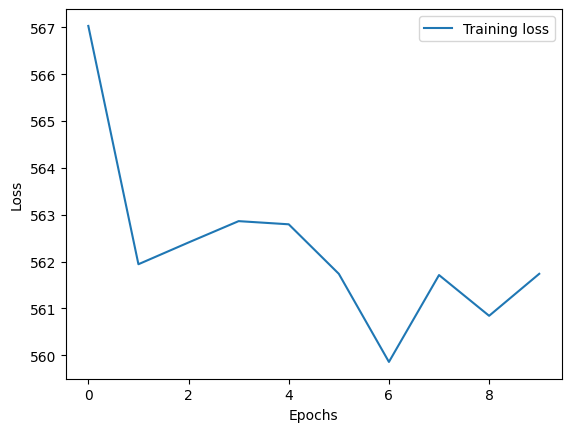

In [22]:
plt.plot(train_history, label="Training loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [23]:
torch.save(model, "../models/lstm.pt")